In [3]:
import anndata as ad
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import os
import pertpy as pt
import scanpy as sc
from scipy.stats import pearsonr

import warnings
warnings.filterwarnings("ignore")

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Note for benchmark: Not a fair comparison if presto not installed? -> Much faster implementation of Wilcoxon Rank Sum Test

# Run Mixscape in pertpy

In [4]:
mdata = pt.dt.papalexi_2021()
sc.pp.highly_variable_genes(mdata["rna"], n_top_genes=2000, flavor='seurat_v3', subset=True)
sc.pp.normalize_total(mdata["rna"])
sc.pp.log1p(mdata["rna"])

mdata["rna"].layers["scaled"] = mdata["rna"].X.copy()
sc.pp.scale(mdata["rna"], layer="scaled")
sc.pp.pca(mdata["rna"], n_comps=50, layer="scaled")

In [5]:
# If you want to ensure that the PCA embeddings are the exact same as those computed by Seurat, load them from a CSV file
#mdata["rna"].obsm["X_pca"] = np.genfromtxt("/Users/mamba/Desktop/PCA_embeddings.csv", delimiter=",", skip_header=1, usecols=range(1, 50))

mixscape_identifier = pt.tl.Mixscape()
mixscape_identifier.perturbation_signature(
    mdata["rna"], "perturbation", "NT", split_by="replicate", n_neighbors=20, n_dims=40,
)

In [6]:
# THe perturbation signature computed by Seurat's Mixscape implementation were stored in a CSV file
orig_pert_signature = pd.read_csv("/Users/mamba/Desktop/PRTB_results.csv", index_col=0)
orig_pert_signature = orig_pert_signature.T.loc[mdata["rna"].obs_names, mdata["rna"].var_names]

Text(0.5, 1.0, 'Correlation: 0.97, p-value: 0.0000')

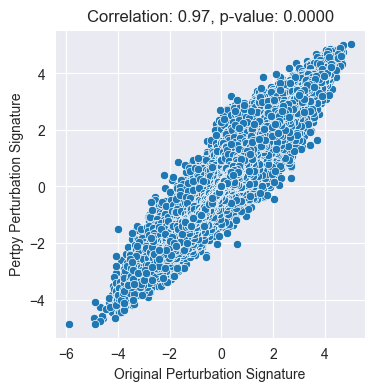

In [7]:
#Correlation between original and pertpy perturbation signature
plt.figure(figsize=(4, 4))
sns.scatterplot(x=orig_pert_signature.values.flatten(), y=mdata["rna"].layers["X_pert"].A.flatten())
plt.xlabel("Original Perturbation Signature")
plt.ylabel("Pertpy Perturbation Signature")

corr_coeff, p_val = pearsonr(orig_pert_signature.values.flatten(), mdata["rna"].layers["X_pert"].A.flatten())
plt.title(f"Correlation: {corr_coeff:.2f}, p-value: {p_val:.4f}")

In [8]:
mixscape_identifier.mixscape(
    adata=mdata["rna"], control="NT", labels="gene_target", layer="X_pert", split_by="replicate"
)

In [9]:
mixscape_identifier.lda(
    adata=mdata["rna"], control="NT", labels="gene_target", split_by="replicate"
)

# Load Mixscape results

In [10]:
adata_pertpy = mdata["rna"]
adata_pertpy

AnnData object with n_obs × n_vars = 20729 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'nCount_GDO', 'nCount_ADT', 'nFeature_ADT', 'percent.mito', 'MULTI_ID', 'HTO_classification', 'guide_ID', 'gene_target', 'NT', 'perturbation', 'replicate', 'S.Score', 'G2M.Score', 'Phase', 'mixscape_class_p_ko', 'mixscape_class', 'mixscape_class_global'
    var: 'name', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'pca', 'mixscape', 'mixscape_lda'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'scaled', 'X_pert'

In [11]:
# Load Mixscape results from Seurat's Mixscape implementation
adata_original = ad.read_h5ad('output/mixscape_original.h5ad')
adata_original

AnnData object with n_obs × n_vars = 20729 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'nCount_GDO', 'nFeature_GDO', 'nCount_ADT', 'nFeature_ADT', 'percent.mito', 'MULTI_ID', 'MULTI_classification', 'MULTI_classification.global', 'HTO_classification', 'guide_ID', 'guide_ID.global', 'gene', 'con', 'NT', 'crispr', 'replicate', 'S.Score', 'G2M.Score', 'Phase', 'mixscape_class', 'mixscape_class_p_ko', 'mixscape_class.global'
    var: 'features'
    obsm: 'X_prtbpca', 'X_prtbumap', 'X_umap'
    varm: 'PRTBPCA'

# Mixscape class comparison

In [12]:
np.all(adata_pertpy.obs_names == adata_original.obs_names)

True

In [13]:
np.all(sorted(adata_pertpy.var_names) == sorted(adata_original.var_names))

True

In [14]:
class_pertpy = adata_pertpy.obs["mixscape_class_global"]
class_original = adata_original.obs["mixscape_class.global"]

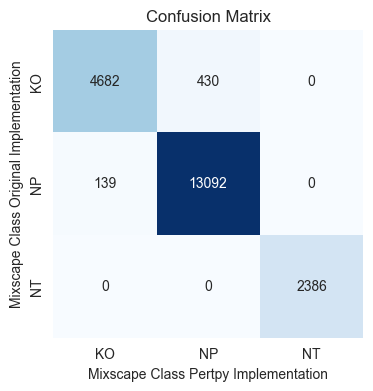

In [15]:
cm = confusion_matrix(class_original, class_pertpy)
unique_classes = sorted(class_original.unique())
cm_df = pd.DataFrame(cm, index=unique_classes, columns=unique_classes)

plt.figure(figsize=(4, 4))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Mixscape Class Pertpy Implementation")
plt.ylabel("Mixscape Class Original Implementation")
plt.title("Confusion Matrix")
plt.show()

# Mixscape Score comparison

In [16]:
# Get genes for which scores are available, i.e. genes for which mixscape identified some KO cells
genes = adata_pertpy.uns["mixscape"].keys()
genes

dict_keys(['CUL3', 'BRD4', 'JAK2', 'SMAD4', 'STAT2', 'IFNGR1', 'STAT1', 'IFNGR2', 'IRF1', 'MYC'])

In [19]:
adata_pertpy.uns["mixscape"]["BRD4"]["rep1"].head(5)

,pvec,gene_target
l1_AAACGGGAGACAGAGA,-0.271535,NT
l1_AAAGCAACAGTGGAGT,-0.799565,NT
l1_AAAGTAGAGGATCGCA,-3.900606,NT
l1_AACCATGGTCTCTCTG,0.787570,BRD4
l1_AACGTTGCAGGTGGAT,-2.483027,BRD4
...,...,...
l4_TTCTTAGCAAAGGCGT,-4.105281,NT
l4_TTGCCGTAGCTATGCT,-0.389937,NT
l4_TTTACTGTCGGACAAG,-1.110052,NT
l4_TTTGGTTGTCTCGTTC,1.076673,BRD4


In [ ]:
keys = []
for gene in adata_pertpy.uns["mixscape"].keys():
    keys.extend(adata_pertpy.uns["mixscape"][gene].keys())
keys = list(set(keys))
keys

In [16]:
# The scores for each gene computed by Seurat's Mixscape implementation were stored in CSV files
csv_dir = "output/gene_csv_files"
prtb_score_dict = {}

# Iterate over each file in the directory
for filename in os.listdir(csv_dir):
    if filename.endswith(".csv"):
        gene_name = filename.replace(".csv", "")
        
        # Load the CSV file into a pandas DataFrame
        file_path = os.path.join(csv_dir, filename)
        prtb_score_dict[gene_name] = pd.read_csv(file_path, index_col=0)

prtb_score_dict.keys()

dict_keys(['NT', 'CUL3', 'MARCH8', 'CD86', 'IFNGR1', 'UBE2L6', 'NFKBIA', 'POU2F2', 'IFNGR2', 'JAK2', 'ATF2', 'IRF7', 'STAT1', 'SMAD4', 'CAV1', 'STAT2', 'STAT3', 'BRD4', 'IRF1', 'PDCD1LG2', 'MYC', 'STAT5A', 'TNFRSF14', 'SPI1', 'ETV7', 'CMTM6'])

In [ ]:
from sklearn.metrics import mean_squared_error
for gene in genes:
    if gene not in prtb_score_dict:
        continue
    
    # Correlate scores per gene
    scores_pertpy = adata_pertpy.uns["mixscape"][gene]["all"]
    scores_original = prtb_score_dict[gene]
    # Bring scores into same order
    scores_pertpy = scores_pertpy.loc[scores_original.index]
    
    mse = mean_squared_error(scores_pertpy["pvec"], scores_original["con1.pvec"])
    pcc = np.corrcoef(scores_pertpy["pvec"], scores_original["con1.pvec"])[0, 1]
    print(f"Gene: {gene}, MSE: {mse}, PCC: {pcc}")